# Segmenting and Clustering Neighborhoods in Toronto

by Juan Camilo Gomez

In [1]:
#Installing necessary packages in case those aren't installed
#!pip install bs4
#!pip install geocoder
#!pip install sklearn
#!pip install folium

Importing the necessary libraries for the rest of the code

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import json
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

### Part 1: Getting list of postal codes, boroughs and neighborhoods 

As a first step, I extracted data related with the postal code, borough and neighborhood using web scrapping. For this, I used the package BeautifulSoup. The data was scrapped from the website: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M. Since I only have interest on the tables contained in this website, I filtered the data to fetch only the tables. By manual inspection, I determined that the table under the index 0 is the table of interest for our application. Then, I extracted the data contained in each cell. 

In [3]:
columns=['Postal Code','Borough','Neighborhood']
neighborhood_data=pd.DataFrame(columns=columns)
neighborhood_data
#Creating beautiful soup object with the wikipedia website containing information about the postal codes
html='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
#Running the request of the determined website
page=requests.get(html).text
#Creating a BeautifulSoup object containing the data
soup=BeautifulSoup(page,'html.parser')
#Filterin to get only the tables
tables = soup.find_all('table')
#Selecting table 0 (table of interest for our application)
tables[0]
#Iterating cell by cell to get the data
cells=tables[0].find_all('td')

After storing the information contained in the cells of the table, I extracted the text (strings) contained in each cell. The cells containing the sentence "Not assigned" in their boroughs were excluded, whereas the text contained in the cases in which the postal codes are assigned were actually sliced to obtain the postal code, borough and neighborhoods. As a final step, the '/' were replaced by ',' to obtain a better format

In [4]:
for cell in cells:
    #First detecting if the key 'Not assigned is contained in the text'
    if 'Not assigned' in cell.text[4:17]:
#    if 'Not assigned' in cell.text:
        pass
    else:
        #Codes are always made of 3 alphanumeric characters. Then selecting those characters to get the PostCode
        post_code=cell.text[1:4]
        #Borough names are next.
        #As the length of the names is not defined, we need to get up to the character '('
        borough=cell.text[4:cell.text.find('(')]
        #Selecting the neighborhoods within parenthesis 
        neighborhoods=cell.text[cell.text.find('(')+1:cell.text.find(')')]
        #Checking condition in case any row is reported with a borough with a neighborhood as 'Not assigned'        
        if 'Not assigned' in neighborhoods:
            neighborhood=borough        
        #Removing ' /' and placing ',' as requested for postal codes covering multiple neighborhoods        
        if ' /' in neighborhoods:
            neighborhoods=neighborhoods.replace(' /',',')
        neighborhood_data = neighborhood_data.append({"Postal Code":post_code, "Borough":borough, 'Neighborhood':neighborhoods}, ignore_index=True)
#Printing dataframe
neighborhood_data

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [5]:
#Getting the shape of the dataframe
neighborhood_data.shape

(103, 3)

Therefore, we can see that we get a dataframe containing 103 rows with assigned postal codes, boroughs and neighborhoods. This means that we have 103 active postal codes. 

In [6]:
print('Unique boroughs:'+str(len(neighborhood_data['Borough'].unique())))
print('Unique sets of neighborhoods:'+str(len(neighborhood_data['Neighborhood'].unique())))

Unique boroughs:15
Unique sets of neighborhoods:98


Moreover, we see that we have 15 unique boroughs and 98 sets of neighborhoods in the dataset. Notice that in some cases the post codes belong to several neighborhoods grouped under a borough. 

### Part 2: Getting coordinates of the different postal codes

As we tried several times to use method1 to get coordinates of each borough but realized this method is too slow, we will use here method2 as a faster alternativeWe will implement both methods: using the geocoder (method1) and merging the data contained in the csv file provided for this purpose (method2). 

In [7]:
#Introducing the selected method to get coordinates of the different postal codes
method='method2'

In [8]:
if method =='method1':
    latitude=[]
    longitude=[]
    for i in np.arange(0,len(neighborhood_data),1):
        postal_code=neighborhood_data.iloc[i,0]
        #print(postal_code)
        # initialize variable to None
        lat_lng_coords = None
        # loop until getting the coordinates
        while(lat_lng_coords is None):
            geodata = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
            lat_lng_coords = geodata.latlng
        latitude.append(lat_lng_coords[0])
        longitude.append(lat_lng_coords[1])
    neighborhood_data_latlng=neighborhood_data
    neighborhood_data_latlng['Latitude']=latitude
    neighborhood_data_latlng['Longitude']=longitude

elif method=='method2':
    #Path to the file containing the post code/Latitude-Longitude data
    path=r'C:\Users\gome_jc\Data_science_capstone\Geospatial_Coordinates.csv'
    #reading data
    latlng_csvdata=pd.read_csv(path)
    #merging the dataframe containing the neighborhood data with the one containing coordinates
    neighborhood_data_latlng=pd.merge(neighborhood_data,latlng_csvdata,on='Postal Code')

#Printing table with latitude and longitude
neighborhood_data_latlng

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


### Part 3: explore and cluster the neighborhoods in Toronto

First, I created a visualization of the different postal codes previously obtained

In [9]:
#In a first step we will visualize the boroughs obtained in the last steps on a map
toronto_lat=neighborhood_data_latlng['Latitude'].mean()
toronto_long=neighborhood_data_latlng['Longitude'].mean()

#create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[toronto_lat, toronto_long], zoom_start=11)

#add markers to map pointing boroughs
for post_code,lat, lng, borough, neighborhood in zip(neighborhood_data_latlng['Postal Code'], neighborhood_data_latlng['Latitude'], neighborhood_data_latlng['Longitude'], neighborhood_data_latlng['Borough'], neighborhood_data_latlng['Neighborhood']):
    label = 'Postal Code: {}; Neighborhoods:{};Borough:{}'.format(post_code, neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
#Showing map    
map_toronto

I filtered the dataset to get only the boroughs named after Toronto

In [10]:
neighborhood_toronto=neighborhood_data_latlng[neighborhood_data_latlng['Borough'].str.contains('Toronto')]
neighborhood_toronto.reset_index(inplace=True,drop=True)
neighborhood_toronto

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
8,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259
9,M4J,East YorkEast Toronto,The Danforth East,43.685347,-79.338106


We can conclude that the dataset was reduced from 103 rows to 39 rows. Checking how many unique boroughs and neighborhoods are obtained after the filtering process. 

In [11]:
print('Unique boroughs:'+str(len(neighborhood_toronto['Borough'].unique())))
print('Unique sets of neighborhoods:'+str(len(neighborhood_toronto['Neighborhood'].unique())))

Unique boroughs:7
Unique sets of neighborhoods:39


Meaning that each postal code corresponds to an unique set of neighborhoods. I will use postal code instead of neighboorhoods for the processing of the data. Plotting again to see the difference between the complete dataset.

In [12]:
#create map of Toronto using latitude and longitude values
map_toronto_2 = folium.Map(location=[toronto_lat, toronto_long], zoom_start=11)

#add markers to map pointing boroughs
for post_code,lat, lng, borough, neighborhood in zip(neighborhood_toronto['Postal Code'], neighborhood_toronto['Latitude'], neighborhood_toronto['Longitude'], neighborhood_toronto['Borough'], neighborhood_toronto['Neighborhood']):
    label = 'Postal Code: {}; Neighborhoods:{};Borough:{}'.format(post_code, neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_2)  
#Showing map    
map_toronto_2

Where we see that we got a reduced dataset. We will cluster this reduced dataset according to the venues available nearby the locations. In the next cells, I will follow mainly the method of the notebook described for the city of New York in the Coursera Data Science Science Capstone course with the small difference of using postal code instead of neighborhood as a reference. 
Defining the credentials to fetch the data from Foursquare.

In [1]:
CLIENT_ID = 'Client_ID' # your Foursquare ID
CLIENT_SECRET = 'Client Secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: Client_ID
CLIENT_SECRET:Client Secret


Creating function to fetch the data from the selected boroughs in Toronto.

In [14]:
def getNearbyVenues(post_codes,borough, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for post_code,borough, lat, lng in zip(post_codes,borough, latitudes, longitudes):
        print(post_code+','+borough)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            post_code, 
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code','Borough','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category']
    
    return(nearby_venues)

In [15]:
#Requesting data to Foursquare
toronto_venues=getNearbyVenues(post_codes=neighborhood_toronto['Postal Code'],borough=neighborhood_toronto['Borough'], latitudes=neighborhood_toronto['Latitude'], longitudes=neighborhood_toronto['Longitude'], radius=500)

M5A,Downtown Toronto
M5B,Downtown Toronto
M5C,Downtown Toronto
M4E,East Toronto
M5E,Downtown Toronto
M5G,Downtown Toronto
M6G,Downtown Toronto
M5H,Downtown Toronto
M6H,West Toronto
M4J,East YorkEast Toronto
M5J,Downtown Toronto
M6J,West Toronto
M4K,East Toronto
M5K,Downtown Toronto
M6K,West Toronto
M4L,East Toronto
M5L,Downtown Toronto
M4M,East Toronto
M4N,Central Toronto
M5N,Central Toronto
M4P,Central Toronto
M5P,Central Toronto
M6P,West Toronto
M4R,Central Toronto
M5R,Central Toronto
M6R,West Toronto
M4S,Central Toronto
M5S,Downtown Toronto
M6S,West Toronto
M4T,Central Toronto
M5T,Downtown Toronto
M4V,Central Toronto
M5V,Downtown Toronto
M4W,Downtown Toronto
M5W,Downtown TorontoStn A PO Boxes25 The Esplanade
M4X,Downtown Toronto
M5X,Downtown Toronto
M4Y,Downtown Toronto
M7Y,East TorontoBusiness reply mail Processing Centre969 Eastern


In [16]:
toronto_venues

,Postal Code,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5A,Downtown Toronto,43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,M5A,Downtown Toronto,43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,M5A,Downtown Toronto,43.654260,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,M5A,Downtown Toronto,43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,M5A,Downtown Toronto,43.654260,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
...,...,...,...,...,...,...,...,...
1575,M7Y,East TorontoBusiness reply mail Processing Cen...,43.662744,-79.321558,Jonathan Ashbridge Park,43.664702,-79.319898,Park
1576,M7Y,East TorontoBusiness reply mail Processing Cen...,43.662744,-79.321558,The Ten Spot,43.664815,-79.324213,Spa
1577,M7Y,East TorontoBusiness reply mail Processing Cen...,43.662744,-79.321558,Toronto Yoga Mamas,43.664824,-79.324335,Yoga Studio
1578,M7Y,East TorontoBusiness reply mail Processing Cen...,43.662744,-79.321558,TTC Stop #03049,43.664470,-79.325145,Light Rail Station


Checking how many venues are present in each postal code

In [17]:
toronto_venues.groupby('Postal Code').count()

,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postal Code,,,,,,,
M4E,4,4,4,4,4,4,4
M4J,4,4,4,4,4,4,4
M4K,41,41,41,41,41,41,41
M4L,20,20,20,20,20,20,20
M4M,36,36,36,36,36,36,36
M4N,3,3,3,3,3,3,3
M4P,9,9,9,9,9,9,9
M4R,22,22,22,22,22,22,22
M4S,33,33,33,33,33,33,33


Counting how many types of venues are present in the data

In [18]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 233 uniques categories.


Analyzing each neighborhood according to the venues. Encoding according to the types of venues obtained in the last step

In [19]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Postal Code'] = toronto_venues['Postal Code'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Postal Code,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
toronto_grouped = toronto_onehot.groupby('Postal Code').mean().reset_index()
toronto_grouped

,Postal Code,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,M4E,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.00000,0.000000,0.25000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,M4J,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,M4K,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.024390,...,0.02439,0.000000,0.02439,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390
3,M4L,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,M4M,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.055556,...,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778
5,M4N,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,M4P,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,M4R,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455
8,M4S,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.00000,0.030303,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,M4T,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.00000,0.000000,0.25000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Function for sorting the venues in desending order

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Getting the 10 most common venues for each postal code

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postal Code'] = toronto_grouped['Postal Code']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,Health Food Store,Trail,Pub,Neighborhood,Park,Other Great Outdoors,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant
1,M4J,Intersection,Convenience Store,Metro Station,Park,Music Venue,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant
2,M4K,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Pizza Place,Brewery,Bubble Tea Shop,Café
3,M4L,Park,Sandwich Place,Fast Food Restaurant,Italian Restaurant,Pet Store,Pub,Restaurant,Movie Theater,Brewery,Fish & Chips Shop
4,M4M,Coffee Shop,Brewery,Café,Gastropub,Bakery,American Restaurant,Yoga Studio,Coworking Space,Seafood Restaurant,Cheese Shop
5,M4N,Park,Bus Line,Swim School,Adult Boutique,Moving Target,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop
6,M4P,Pizza Place,Breakfast Spot,Playground,Gym / Fitness Center,Park,Hotel,Food & Drink Shop,Sandwich Place,Department Store,Monument / Landmark
7,M4R,Clothing Store,Coffee Shop,Health & Beauty Service,Mexican Restaurant,Diner,Fast Food Restaurant,Furniture / Home Store,Ice Cream Shop,Italian Restaurant,Park
8,M4S,Pizza Place,Dessert Shop,Sandwich Place,Coffee Shop,Café,Sushi Restaurant,Gym,Italian Restaurant,Diner,Gas Station
9,M4T,Restaurant,Park,Gym,Trail,Museum,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop


Clustering the different postal codes. I arbitrarily chose 3 clusters, but we will see if we can optimize the number of clusters to get the best clustering model. 

In [23]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Postal Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = neighborhood_toronto

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Postal Code'), on='Postal Code')

toronto_merged

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Bakery,Park,Breakfast Spot,Café,Theater,Pub,Mexican Restaurant,French Restaurant,Shoe Store
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Coffee Shop,Clothing Store,Japanese Restaurant,Cosmetics Shop,Middle Eastern Restaurant,Hotel,Café,Bubble Tea Shop,Italian Restaurant,Pizza Place
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Café,Coffee Shop,Cocktail Bar,Gastropub,Restaurant,Lingerie Store,Theater,Clothing Store,Seafood Restaurant,Cosmetics Shop
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Trail,Pub,Neighborhood,Park,Other Great Outdoors,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,2,Coffee Shop,Cocktail Bar,Bakery,Pharmacy,Seafood Restaurant,Cheese Shop,Beer Bar,Restaurant,Farmers Market,Creperie
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,2,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Burger Joint,Bubble Tea Shop,Japanese Restaurant,Salad Place,Thai Restaurant,Poke Place
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564,2,Grocery Store,Café,Park,Nightclub,Baby Store,Candy Store,Italian Restaurant,Restaurant,Coffee Shop,Moving Target
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,2,Coffee Shop,Café,Restaurant,Gym,Hotel,Clothing Store,Deli / Bodega,Thai Restaurant,Concert Hall,Cosmetics Shop
8,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,2,Pharmacy,Bakery,Liquor Store,Brewery,Music Venue,Supermarket,Furniture / Home Store,Café,Bar,Bank
9,M4J,East YorkEast Toronto,The Danforth East,43.685347,-79.338106,1,Intersection,Convenience Store,Metro Station,Park,Music Venue,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant


Visualizing the results of the clustering

In [24]:
# create map
map_clusters_3 = folium.Map(location=[toronto_lat, toronto_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Postal Code'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_3)
       
map_clusters_3

Where we can actually see that most of the data per postal code can is allocated to the cluster 1. Confirming this

In [25]:
toronto_merged.groupby('Cluster Labels').count()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34


In [26]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Trail,Pub,Neighborhood,Park,Other Great Outdoors,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant


In [27]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,M4J,East YorkEast Toronto,The Danforth East,43.685347,-79.338106,1,Intersection,Convenience Store,Metro Station,Park,Music Venue,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant
18,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Park,Bus Line,Swim School,Adult Boutique,Moving Target,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop
29,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,1,Restaurant,Park,Gym,Trail,Museum,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop
33,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,1,Park,Playground,Trail,Adult Boutique,Museum,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop


In [28]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Bakery,Park,Breakfast Spot,Café,Theater,Pub,Mexican Restaurant,French Restaurant,Shoe Store
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Coffee Shop,Clothing Store,Japanese Restaurant,Cosmetics Shop,Middle Eastern Restaurant,Hotel,Café,Bubble Tea Shop,Italian Restaurant,Pizza Place
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Café,Coffee Shop,Cocktail Bar,Gastropub,Restaurant,Lingerie Store,Theater,Clothing Store,Seafood Restaurant,Cosmetics Shop
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,2,Coffee Shop,Cocktail Bar,Bakery,Pharmacy,Seafood Restaurant,Cheese Shop,Beer Bar,Restaurant,Farmers Market,Creperie
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,2,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Burger Joint,Bubble Tea Shop,Japanese Restaurant,Salad Place,Thai Restaurant,Poke Place
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564,2,Grocery Store,Café,Park,Nightclub,Baby Store,Candy Store,Italian Restaurant,Restaurant,Coffee Shop,Moving Target
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,2,Coffee Shop,Café,Restaurant,Gym,Hotel,Clothing Store,Deli / Bodega,Thai Restaurant,Concert Hall,Cosmetics Shop
8,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,2,Pharmacy,Bakery,Liquor Store,Brewery,Music Venue,Supermarket,Furniture / Home Store,Café,Bar,Bank
10,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,2,Coffee Shop,Aquarium,Café,Hotel,Fried Chicken Joint,Scenic Lookout,Italian Restaurant,Restaurant,Sporting Goods Shop,Brewery
11,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,2,Bar,Coffee Shop,Asian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Men's Store,Café,Pizza Place,Gift Shop


However, we are defining beforehand the number of clusters. Therefore, we will optimize this parameter. We will use the methodology described here: https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

In [29]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(toronto_grouped_clustering)
    kmeanModel.fit(toronto_grouped_clustering)
 
    distortions.append(sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / toronto_grouped_clustering.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / toronto_grouped_clustering.shape[0]
    mapping2[k] = kmeanModel.inertia_

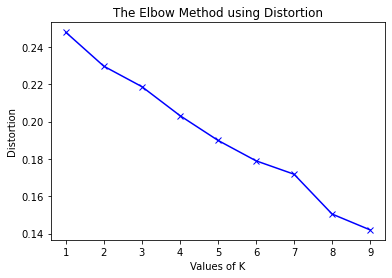

In [30]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

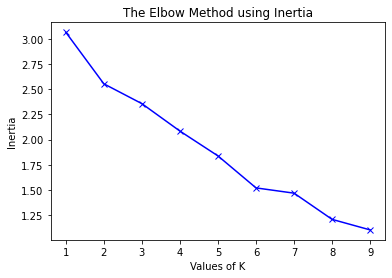

In [31]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

From the former analysis, we can conclude that there is no "elbow" in terms of distortion or inertia when k is modified in the k-means algorithm for this particular dataset. Therefore, increasing k does not considerably increase the quality of our model

From the clustering excercise, we can conclude that the first cluster with a single postal code is surrounded by venues such as health food stores, pubs, parks, men's stores, mexican restaurants and middle eastern restaurants. Cluster 2 contain all the other postal codes with a great variety of venues. Cluster 3 contain mainly postal codes and hence neighborhoods with venues such as parks, men's stores, mexican restaurants and miscellaneous stores and is relatively similar to cluster 1.  